## Importing the Data

In [ ]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [17]:
import pandas as pd
import numpy as np
import matplotlib as plt
#import scikit-learn as sci
import scanpy as sc
#import Leidenalg as ld

In [18]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 pynndescent==0.5.5


In [49]:
#path = "C:/Users/Schlumi/Desktop/IIIBiophysik21-22/Organoids/data_organoids/"
#adata = sc.read(path + "GSM3689561_G9_filtered_feature_bc_matrix.h5/", cache=True).T
#adata.var_names = pd.read.csv(path + "features.tsv", header=None, sep="\t")[1]
#adata.obs_names = pd.read_csv(path + "barcodes.tsv", header=None)[0]

adata = sc.read_10x_mtx(
    'C:/Users/Schlumi/Desktop/IIIBiophysik21-22/Organoids/data/sample1_control_day6',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
adata.var_names_make_unique()

... reading from cache file cache\C-Users-Schlumi-Desktop-IIIBiophysik21-22-Organoids-data-sample1_control_day6-matrix.h5ad


## Preprocessing the Data

normalizing counts per cell


C:\Users\Schlumi\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished (0:00:01)


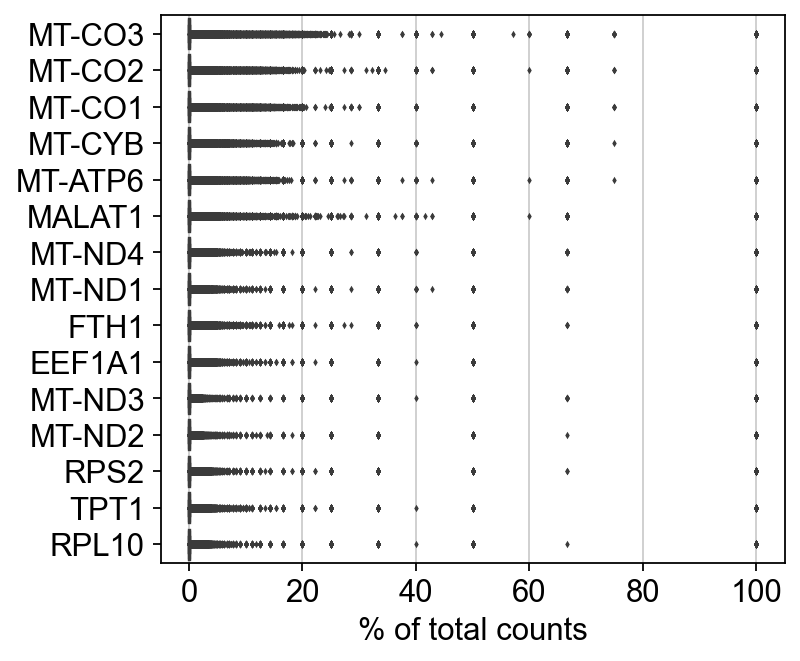

In [50]:
sc.pl.highest_expr_genes(adata, n_top=15, ) #ln8

#pl.savefig("Scanpy_Example.pdf")

In [51]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3) #ln9

filtered out 6754249 cells that have less than 100 genes expressed
filtered out 13635 genes that are detected in less than 3 cells


In [52]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #ln10

... storing 'feature_types' as categorical


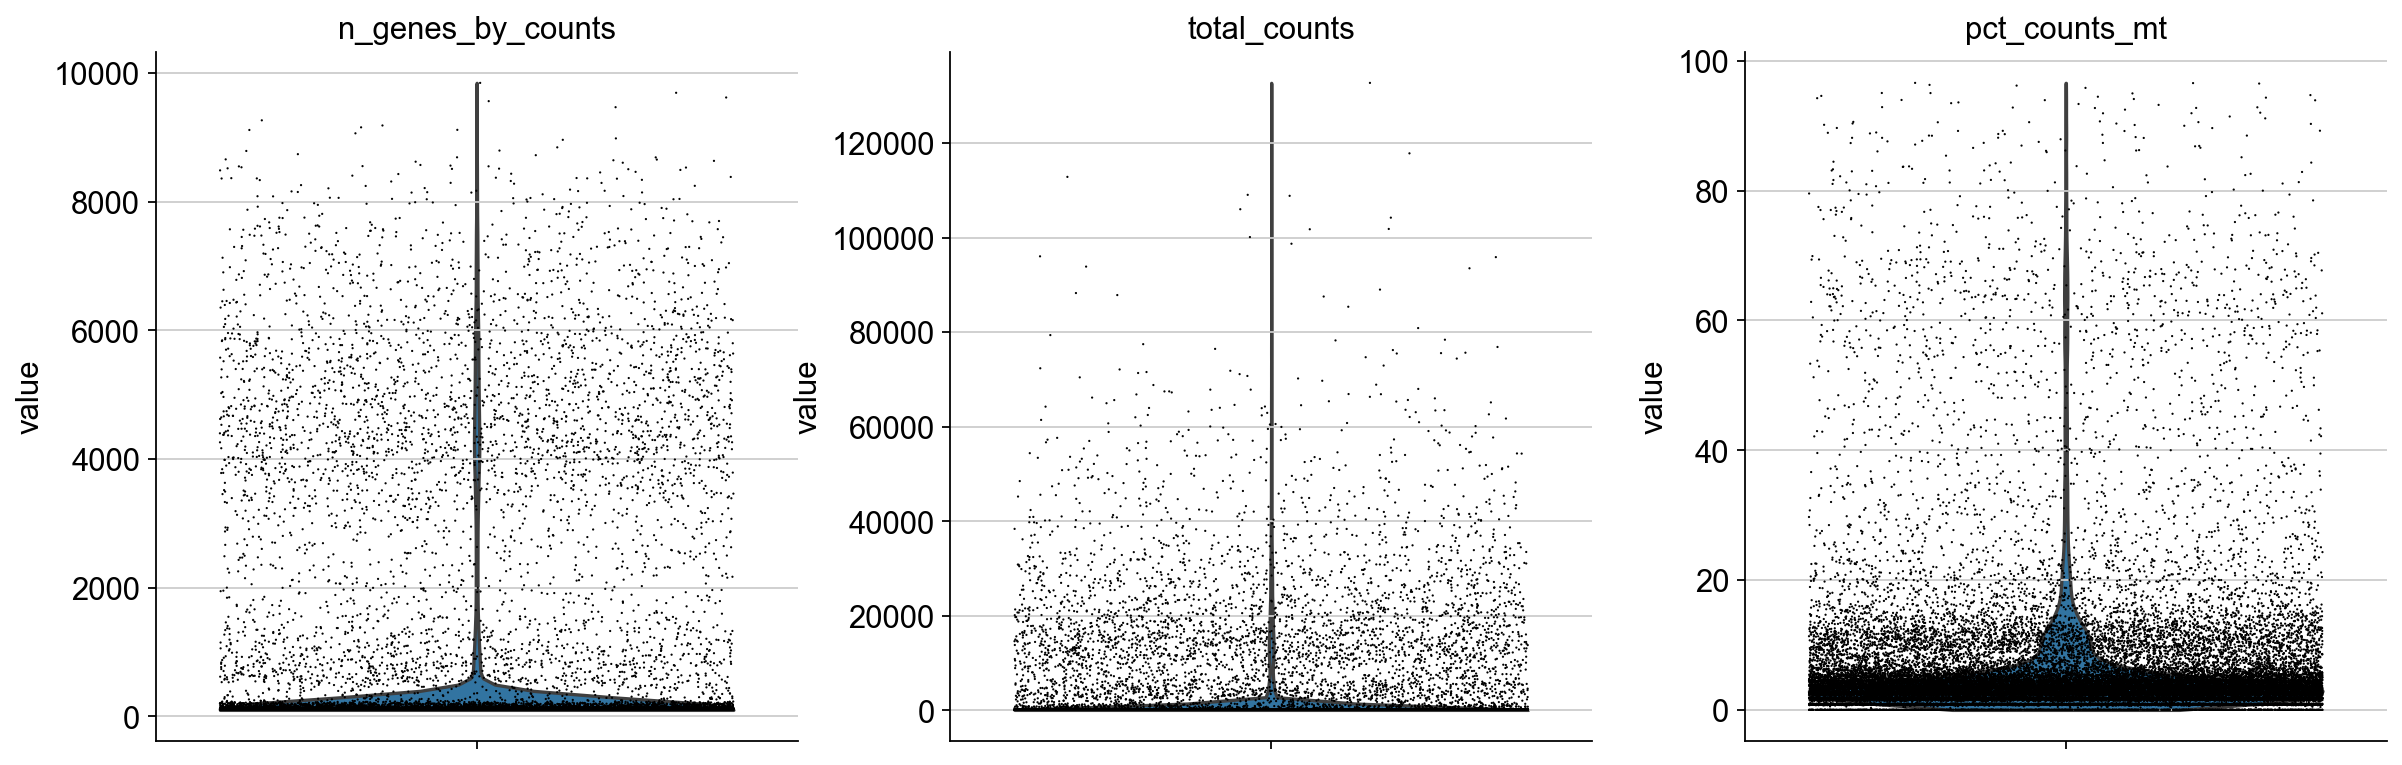

In [53]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True) #ln11

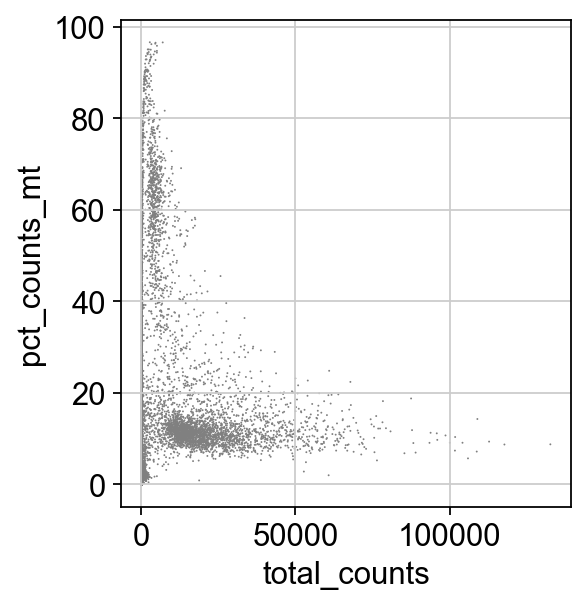

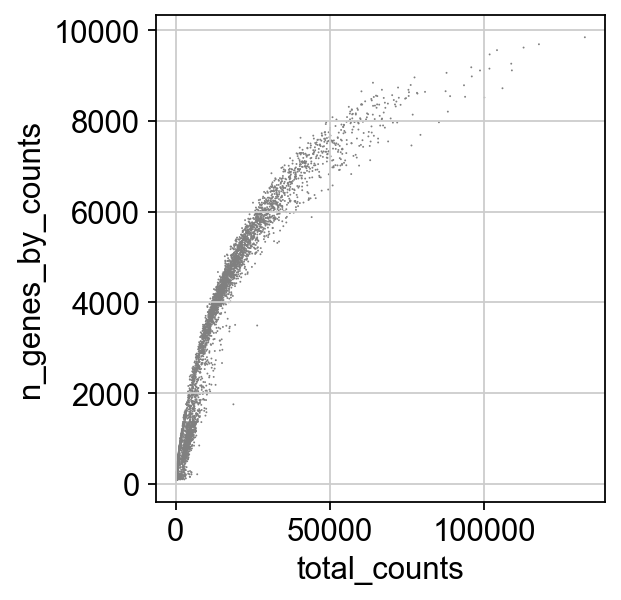

In [54]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts') #ln12

In [55]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :] #ln13

In [56]:
sc.pp.normalize_total(adata, target_sum=1e4) #ln14

normalizing counts per cell


C:\Users\Schlumi\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


In [57]:
sc.pp.log1p(adata) #ln15

In [58]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #ln16

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


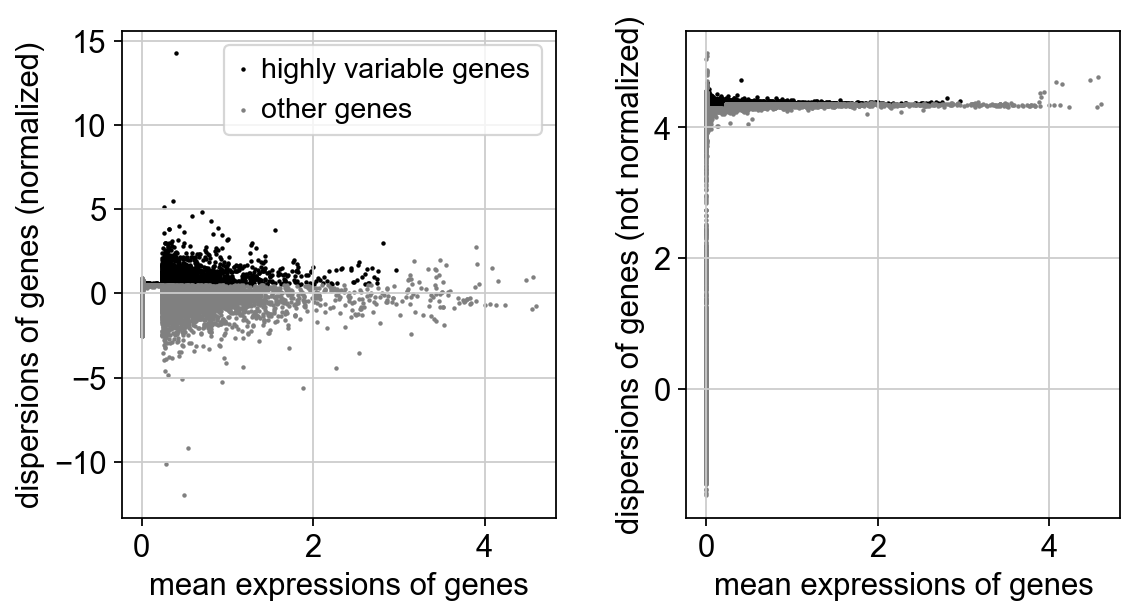

In [60]:
sc.pl.highly_variable_genes(adata) #ln17

In [61]:
#adata.raw = adata #ln18

In [62]:
adata = adata[:, adata.var.highly_variable] #19

In [63]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #20

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:07:06)


In [34]:
sc.pp.scale(adata, max_value=10) #ln21

## Principal Component Analysis (PCA)

In [35]:
sc.tl.pca(adata, svd_solver='arpack') #ln22

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:13)


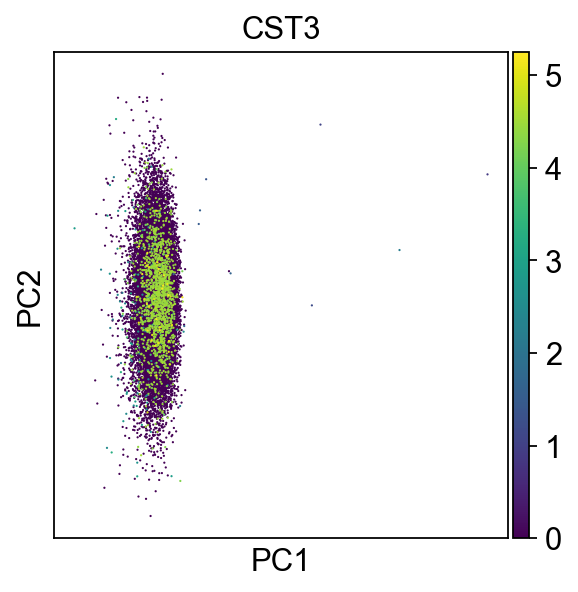

In [36]:
sc.pl.pca(adata, color='CST3') #ln23

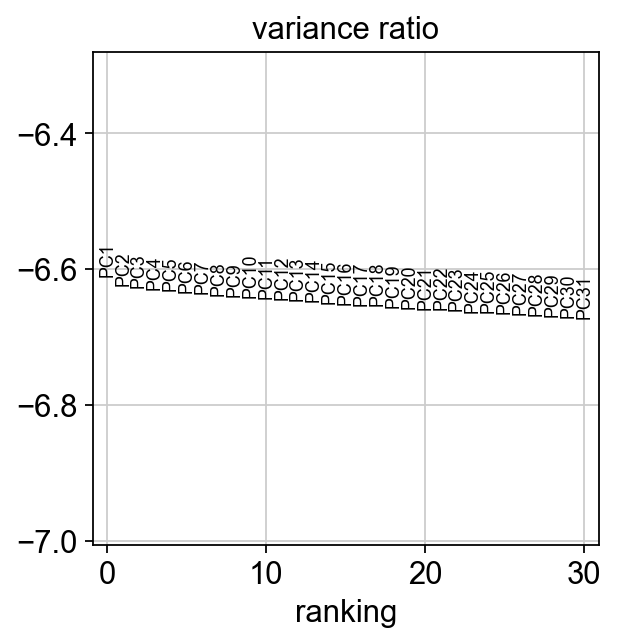

In [37]:
sc.pl.pca_variance_ratio(adata, log=True) #ln24

In [ ]:
#adata.write(results_file) #ln25

In [38]:
adata

AnnData object with n_obs × n_vars = 30309 × 1427
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [39]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


## Embedding the neighborhood graph

In [40]:
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')

NameError: name 'tl' is not defined

In [ ]:
sc.tl.umap(adata) #ln28

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP']) #ln29

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False) #ln30

## Clustering the neighborhood graph

In [ ]:
#sc.tl.leiden(adata) #ln31

In [ ]:
#sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7']) #ln32

In [ ]:
#adata.write(results_file) #ln33

## Finding marker genes

In [ ]:
#sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) #ln34

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity #ln35

In [ ]:
#sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) #ln36

In [ ]:
#adata.write(results_file) #ln37

In [ ]:
#sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) #ln38

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP'] #ln39

In [ ]:
#adata = sc.read(results_file) #ln40

In [ ]:
#pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5) #ln41

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5) #ln42

In [ ]:
#Compare to a single cluster

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20) #ln43